In [1]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from scipy.optimize import fsolve
from modeling.utils.qubits import get_Ic_from_Lj, jaynes_cummings_g
from qucat import Network,L,J,C
from modeling.qubits.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
from modeling.utils.constants import planck_h, e_charge, phi0
from scqubits import Transmon

In [2]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

# Target Parameters

In [3]:
a = 10e-6 # conductor width
b = 6e-6 # gap width
ep_r = 11.45 # substrate relative permittivity

nb_qubits = 6 # number of qubits / readout resonators
rr_freq_target = np.array([7.0e9, 7.15e9, 7.6e9, 7.45e9, 7.3e9, 7.70e9]) # target readout resonator frequencies
qubit_freq_target = np.array([5e9, 5.15e9, 5.6e9, 5.45e9, 5.3e9, 5.7e9]) # target qubit frequencies
c_sigma = 90.47e-15 # target qubit shunt capacitance
kappa_target = 1e6 # target resonator linewidth
chi = 0.65e6 # target dispersive shift

Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [4]:
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real # characteristic impedance of the CPW
l_r = Z0*pi/(4*pi*rr_freq_target) # Effective resonator L
c_r = 1/((2*pi*rr_freq_target)**2*l_r) # Effective resonator C

# Design optimization

In [5]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    """Function to minimize the error in chi and qubit frequency by varying
    the coupling capacitor and Josephson inductance."""
    cir = Network([
        C(0, 1, c_sigma), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r), # resonator
        L(0,2,l_r),
        C(1,2, abs(x[0])*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1] - 2*chi)
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [6]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [6, 9], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print("Coupling capacitance for each qubit to their readout resonators [F]", cqrs)
print("Josephson inductance for each qubit [H]", Ljs)

Coupling capacitance for each qubit to their readout resonators [F] [4.73819862e-15 4.57738216e-15 4.14617593e-15 4.28203470e-15
 4.42555966e-15 4.05957980e-15]
Josephson inductance for each qubit [H] [9.78531890e-09 9.26083930e-09 7.91764806e-09 8.33092814e-09
 8.77743723e-09 7.65898218e-09]


In [7]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h
anharmonicities = np.zeros(nb_qubits)
for i in range(nb_qubits):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

Energy dispersion is  1.0481692886352539e-07 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

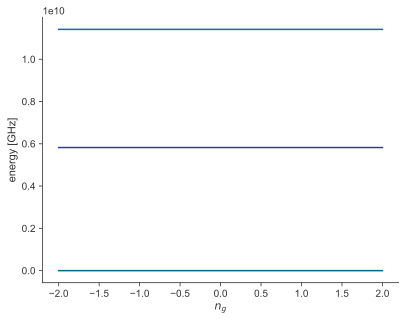

In [8]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [9]:
# Printout of the mode analysis for each qubit+resonator system
resonator_mode = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma), # transmon
        J(0,1, Ljs[i]),
        C(0,2,c_r[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        ])
    cir.f_k_A_chi(pretty_print=True)
    H  = cir.hamiltonian(modes = [0, 1],
                taylor = 6, excitations = [10, 10])
    ee = H.eigenenergies().real
    ee -= ee[0]
    resonator_mode[i] = ee[2]

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.21 GHz |          0Hz |      202 MHz |
            1 |     6.95 GHz |          0Hz |     2.09 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      202 MHz |              |
            1 |      1.3 MHz |     2.09 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.36 GHz |          0Hz |      203 MHz |
            1 |      7.1 GHz |          0Hz |     2.09 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      203 MHz |              |
            1 |      1.3 MHz |     2.09 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.81 GHz |          0Hz |      204 MHz |
            1 |     7.55 GHz |          0Hz |     2.08 kHz |

Kerr coefficients (diagonal = Kerr, off-diag

In [10]:
print("Loaded resonator frequencies", resonator_mode)
resonator_mode_shift = rr_freq_target - resonator_mode

Loaded resonator frequencies [6.94828235e+09 7.09777907e+09 7.54629017e+09 7.39678297e+09
 7.24727928e+09 7.64596356e+09]


In [11]:
# Coupling strength and Lamb shift calculation (approximate)
gs = jaynes_cummings_g(Ej, EC, cqrs, c_r, rr_freq_target, lambda_half = False)
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*gs**2 / delta
print("Coupling strengths g/2pi [Hz]: ", gs/2/pi)
print("Lamb shifts [Hz]: ", lamb_shift/2/pi)

Coupling strengths g/2pi [Hz]:  [1.27061164e+08 1.30667691e+08 1.41496904e+08 1.37885684e+08
 1.34275886e+08 1.43905131e+08]
Lamb shifts [Hz]:  [27449613.58857331 25746813.69756525 22542738.91273011 23381196.63933413
 24425888.74338035 22073919.03834667]


In [12]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0, lambda_half = False)/ 2/ pi
    return abs(k - kappa_target)
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15
print("Coupling capacitance to feedline for each resonator [F]: ", cks)

Coupling capacitance to feedline for each resonator [F]:  [6.69107791e-15 6.48162773e-15 5.91456431e-15 6.09408823e-15
 6.28288133e-15 5.79972043e-15]


In [13]:
adjusted_resonator_frequencies = rr_freq_target + resonator_mode_shift
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / adjusted_resonator_frequencies / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= cqrs
c_r_loaded -= cks
resonator_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
resonator_waveguide_lengths

array([0.00834556, 0.00817319, 0.00769638, 0.007849  , 0.00800781,
       0.0075979 ])

In [14]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_coupling = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_coupling(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Coupler width for qubit 0: 142.37 um
Finger control for qubit 0: 1.9321
Resonator length for qubit 0: 8345.6 um
Coupler width for qubit 1: 135.9 um
Finger control for qubit 1: 1.9071
Resonator length for qubit 1: 8173.2 um
Coupler width for qubit 2: 118.6 um
Finger control for qubit 2: 1.8366
Resonator length for qubit 2: 7696.4 um
Coupler width for qubit 3: 124.04 um
Finger control for qubit 3: 1.8593
Resonator length for qubit 3: 7849.0 um
Coupler width for qubit 4: 129.8 um
Finger control for qubit 4: 1.8829
Resonator length for qubit 4: 8007.8 um
Coupler width for qubit 5: 115.12 um
Finger control for qubit 5: 1.8217
Resonator length for qubit 5: 7597.9 um


# Quasi-lumped simulation

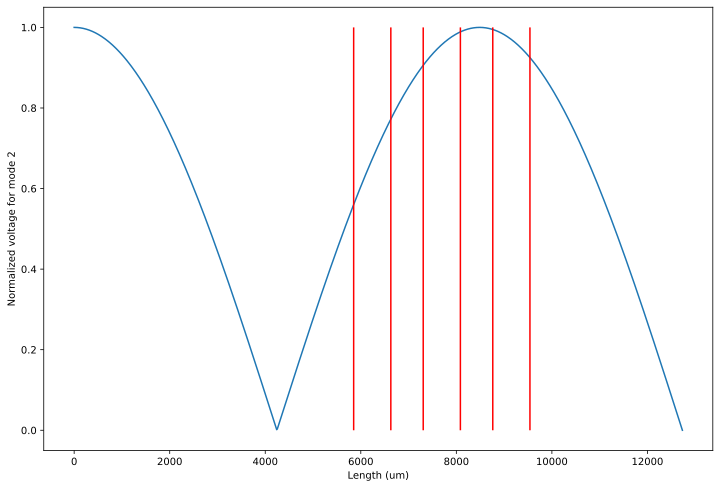

In [15]:
fl_traits = pd.read_csv("single_doublepads_00.csv").values[0][1:]
tee_size = pd.read_csv("single_doublepads_00.csv").values[1][1:]
res_length = pd.read_csv("single_doublepads_00.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = [
    float(fl_traits[0]), # From input launcher to feedline capacitor
    fl_traits[1] + (a + 2*b)/2, # From feedline capacitor to tee0
    fl_traits[2] + (a + 2*b), # From tee0 to tee1
    fl_traits[3] + (a + 2*b), # From tee1 to tee2
    fl_traits[4] + (a + 2*b), # From tee2 to tee3
    fl_traits[5] + (a + 2*b), # From tee3, to tee4 
    fl_traits[6] + (a + 2*b), # From tee4, to tee5
    fl_traits[7] + (a + 2*b), # From tee5, to tee6 (from tee6 we split into output launcher and feedline resonator tail)
    fl_traits[8] + (a + 2*b)/2, # From tee6 to output launcher
    fl_traits[9] + 30, # from tee6 to ground (feedline resonator tail endpoint)
]

feedline_res_length = fl_traits[1] + (a + 2*b)/2 + \
    fl_traits[2] + (a + 2*b) + \
    fl_traits[3] + (a + 2*b) + \
    fl_traits[4] + (a + 2*b) + \
    fl_traits[5] + (a + 2*b) + \
    fl_traits[6] + (a + 2*b) + \
    fl_traits[7] + (a + 2*b) + \
    fl_traits[8] + 30 + fl_traits[9] + (a + 2*b)/2
qb_pos_0 = fl_traits[1] + (a + 2*b)/2
qb_pos_1 = qb_pos_0 + fl_traits[2] + (a + 2*b)
qb_pos_2 = qb_pos_1 + fl_traits[3] + (a + 2*b)
qb_pos_3 = qb_pos_2 + fl_traits[4] + (a + 2*b)
qb_pos_4 = qb_pos_3 + fl_traits[5] + (a + 2*b)
qb_pos_5 = qb_pos_4 + fl_traits[6] + (a + 2*b)

xdata = np.linspace(0, feedline_res_length, 1001)
plt.figure(figsize=(12, 8))
plt.ylabel("Normalized voltage for mode 2")
plt.xlabel("Length (um)")
def resonance_profile(x, total_length, order):
    return abs(np.cos(2*np.pi*x*(order + 1/2)/total_length/2))
plt.plot(xdata, resonance_profile(xdata, feedline_res_length, order = 1))
plt.vlines([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3, qb_pos_4, qb_pos_5], ymin = 0, ymax = 1, colors="r")
corrections_to_ck = resonance_profile(np.array([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3, qb_pos_4, qb_pos_5]), feedline_res_length, order = 1)

In [16]:
# resonator_capacitance = c_r_loaded - cks -  cqrs
# resonator_mode
l_r_mode = Z0*pi/(4*pi*resonator_mode)
c_r_mode = 1/((2*pi*resonator_mode)**2*l_r)- cks -  cqrs
cfl = 5e-14
options = {
    "qubit_c": np.array([c_sigma]*6),
    "qubit_l": Ljs,
    "readout_resonator_c": c_r_mode,
    "readout_resonator_l": l_r_mode,
    "ck": cks,
    "ck_to_ground": ck_to_ground(cks),
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "cfl_to_ground": ck_to_ground(cfl),
    "frequency": [2, 8],
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}

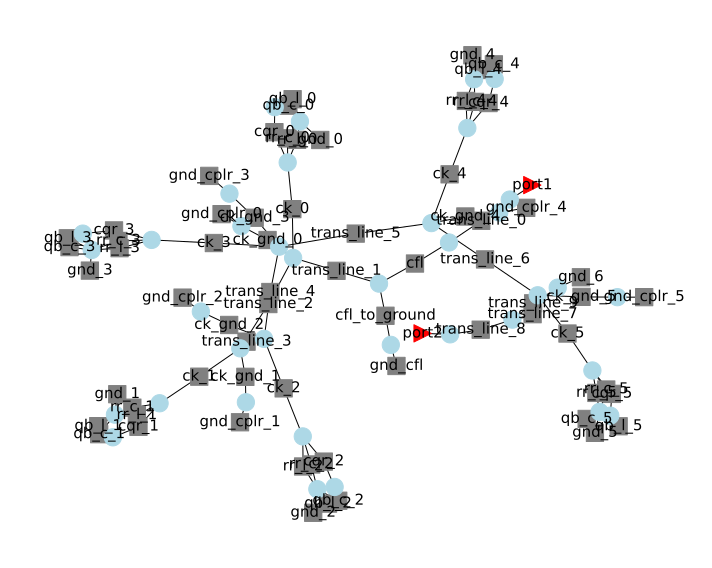

In [17]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)
ntw = cir.network

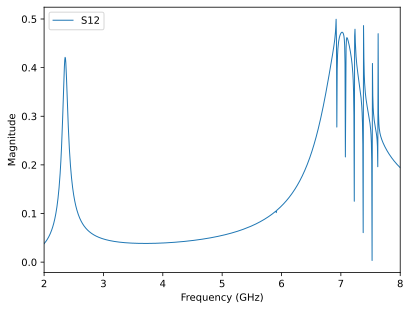

In [18]:
ntw.plot_s_mag(m=0, n=1, lw=1)

In [19]:
# T1 Purcell:
k_purcell = kappa_target* (gs/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell)
print("T1 Purcell-limited [us]", T1_purcell)

T1 Purcell-limited [us] [1.36405949e-05 1.63971956e-05 2.50819118e-05 2.21403769e-05
 1.92386868e-05 2.70566354e-05]


In [20]:
df = pd.DataFrame(['qb0','qb1','qb2', 'qb3', 'qb4', 'qb5'])
df['resonator 01 [GHz]'] = rr_freq_target / 1e9
df['qubit 01 [GHz]'] = qubit_freq_target / 1e9
df['anharmonicity [MHz]'] = anharmonicities / 1e6
df['chi/2pi [MHz]'] = [chi / 1e6]*nb_qubits
df['g/2pi [MHz]'] = gs/2/np.pi / 1e6
df['C_sigma [fF]'] = [c_sigma*1e15]*nb_qubits
df["Lj  [nH]"] = Ljs *1e9
df['Ic [nA]'] = Ic*1e9
df['T1 Purcell [us]'] = T1_purcell * 1e6
df.T

,0,1,2,3,4,5
0,qb0,qb1,qb2,qb3,qb4,qb5
resonator 01 [GHz],7.0,7.15,7.6,7.45,7.3,7.7
qubit 01 [GHz],5.0,5.15,5.6,5.45,5.3,5.7
anharmonicity [MHz],-237.931289,-237.125554,-235.009923,-235.669888,-236.373551,-234.592209
chi/2pi [MHz],0.65,0.65,0.65,0.65,0.65,0.65
g/2pi [MHz],127.061164,130.667691,141.496904,137.885684,134.275886,143.905131
C_sigma [fF],90.47,90.47,90.47,90.47,90.47,90.47
Lj [nH],9.785319,9.260839,7.917648,8.330928,8.777437,7.658982
Ic [nA],33.632627,35.537381,41.566129,39.504119,37.494541,42.969937
T1 Purcell [us],13.640595,16.397196,25.081912,22.140377,19.238687,27.056635
